## UK energy production -- exploration data analyses

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import fill_between
from hampel import hampel
from scipy import stats
import numpy as np

In [2]:
#colors
tableau_colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

for i in range(len(tableau_colors)):    
    r, g, b = tableau_colors[i]    
    tableau_colors[i] = (r / 255., g / 255., b / 255.)

In [3]:
def duplicates(df):
    table=[]
    #print("Number of duplicates per column")
    for col in df.columns:
       # print( "  {:>20s}: {:>5d}".format(col, df[col].duplicated().sum()))
        table.append([col, df[col].duplicated().sum()])
    #display_table(table)
    return table

In [6]:
#This function needs also improvements. It supposes that there are only two levels in a column.index.
#checks of the input are necessary try except...
def after_groupby(df, reset=True, second_level_keep=True, columns_transform=True):
    if(columns_transform):
        if second_level_keep:
            df.columns=[str(col[0]+' '+col[1]) for col in df.columns]
        else:
            df.columns=[str(col[0]) for col in df.columns]
    else:
        df.columns=df.columns
    if reset:
        df=df.reset_index()
    return df

def print_header(s):
    print(s)
    print("-"*len(s))

    
from IPython.display import HTML, display

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))
    
def proportion_nones(df):
    table=[]
    #print("Proportion of NANs in each column:")
    for col in df.columns:
        if (df[col].isna().sum()!=0):
            percent=(df[col].isna().sum()/df.shape[0])*100
            #print("{:>20s}: {:>5f}".format(col, percent))
            table.append([col, round(percent, 3)])
    #display_table(table)
    return table     
    
def duplicates_prop_nones(df):
    tables_to_print2=[]
    tables_to_print2.append(duplicates(df))
    tables_to_print2.append(proportion_nones(df))
    return tables_to_print2 

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

def print_info_list_DFs_duplicates(df_list):
    for name, df in df_list.items():
        print_header(name)
        tables_to_print2=duplicates_prop_nones(df)
        dp0=pd.DataFrame(tables_to_print2[0]).rename(columns={0:"Column", 1:"Nb.duplicates"})
        dp1=pd.DataFrame(tables_to_print2[1]).rename(columns={0:"Column", 1:"Proportion NaNs in columns with NaNs"})
        if(len(dp1)==0):
            display_side_by_side([dp0.set_index("Column")], ['Nb.duplicates'])
        else:
            display_side_by_side([dp0.set_index("Column"),dp1.set_index("Column")], ['Nb.duplicates', 'Proportion NaNs in each column'])

In [5]:
df = pd.read_csv('energy_use_in_the_UK.csv', sep=";", parse_dates=True)
df.rename(columns={' timestamp': 'timestamp', " coal": "coal", " nuclear": "nuclear", " wind": "wind"," hydro": "hydro", " solar": "solar"}, inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796453 entries, 0 to 796452
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  796453 non-null  object 
 1   coal       796453 non-null  int64  
 2   nuclear    796453 non-null  int64  
 3   wind       796453 non-null  int64  
 4   hydro      796453 non-null  int64  
 5   solar      796453 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 36.5+ MB


In [7]:
print_info_list_DFs_duplicates({'Energy':df})

Energy
------


,Nb.duplicates
Column,
timestamp,52
coal,771987
nuclear,790947
wind,784608
hydro,795067
solar,791331


In [8]:
print("Number of unique timestamps : %d"\
      "\nnumber of (timestamp) uniques : %d"%(
df['timestamp'].nunique(),
df.groupby(['timestamp']).nunique().shape[0]))

Number of unique timestamps : 796401
number of (timestamp) uniques : 796401


#### Dropping non-unique values related to timesteps 

In [9]:
df.drop_duplicates(subset=['timestamp'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796401 entries, 0 to 796452
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  796401 non-null  object 
 1   coal       796401 non-null  int64  
 2   nuclear    796401 non-null  int64  
 3   wind       796401 non-null  int64  
 4   hydro      796401 non-null  int64  
 5   solar      796401 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 42.5+ MB


In [11]:
df['Datetime']=pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [12]:
df['Date'] = df['Datetime'].dt.date
df['Time'] = df['Datetime'].dt.time
df['Year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month.astype(int)
df['day_of_month'] = df['Datetime'].dt.day.astype(int)

# day_of_week=0 corresponds to Monday
df['day_of_week'] = df['Datetime'].dt.dayofweek.astype(int)
df['hour_of_day'] = df['Datetime'].dt.hour.astype(int)
df['day_of_week_name'] = df['Datetime'].dt.day_name()
df['month_name'] = df['Datetime'].dt.month_name()

Text(0.5, 1.0, 'Evolution of the energy production of UK')

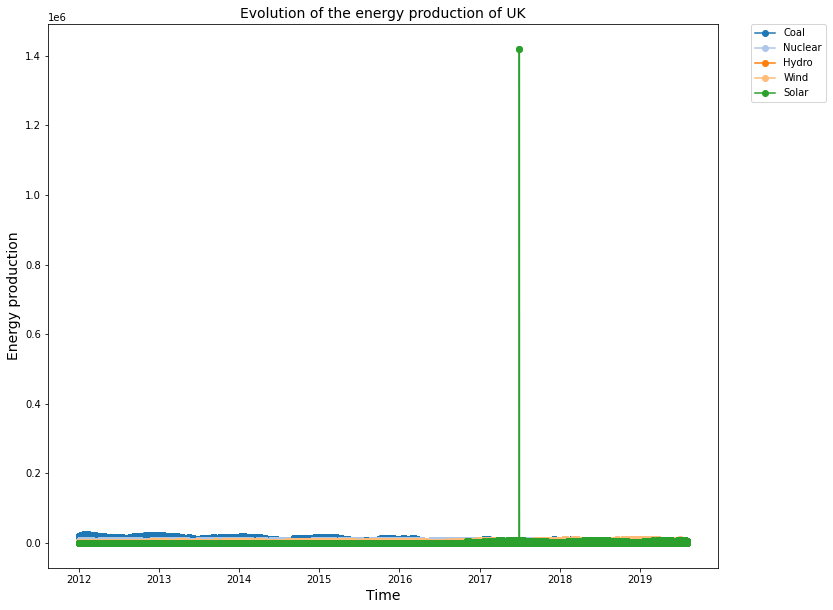

In [15]:
fig = plt.figure(figsize=(12,10))
plt.plot(df.Datetime, df.coal, 'o-',label='Coal',color=tableau_colors[0])
plt.plot(df.Datetime, df.nuclear, 'o-',label='Nuclear',color=tableau_colors[1])
plt.plot(df.Datetime, df.hydro, 'o-',label='Hydro',color=tableau_colors[2])
plt.plot(df.Datetime, df.wind, 'o-',label='Wind',color=tableau_colors[3])
plt.plot(df.Datetime, df.solar, 'o-',label='Solar',color=tableau_colors[4])
plt.xlabel('Time', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Energy production',  fontsize=14)
plt.title('Evolution of the energy production of UK', fontsize=14)

Text(0.5, 1.0, 'Evolution of the energy production in UK')

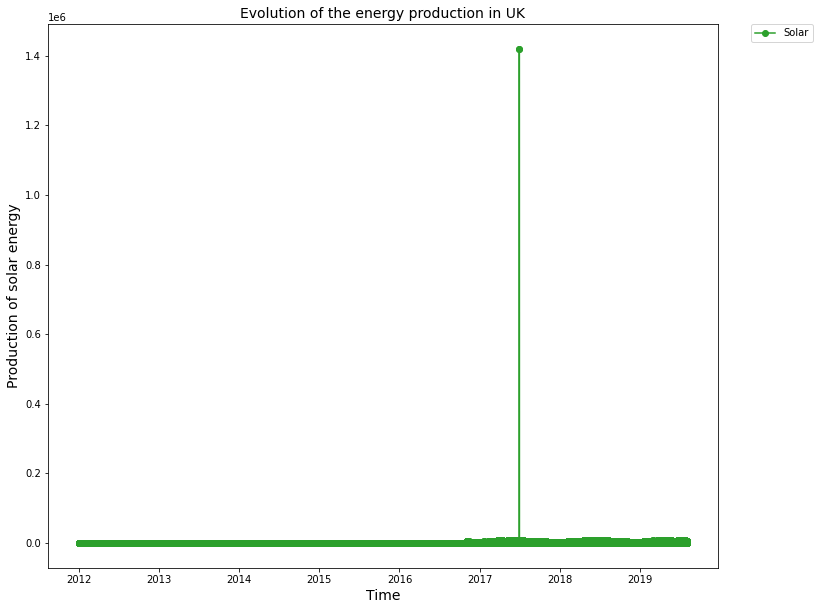

In [17]:
fig = plt.figure(figsize=(12,10))
plt.plot(df.Datetime, df.solar, 'o-',label='Solar',color=tableau_colors[4])
plt.xlabel('Time', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Production of solar energy',  fontsize=14)
plt.title('Evolution of the energy production in UK', fontsize=14)

In [19]:
# Just outlier detection 
outlier_indices = hampel(df['solar'], window_size=103680, n=3)
print("Outlier Indices: ", outlier_indices)

In [23]:
# df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df = df[np.abs(df.solar-df.solar.mean()) <= (3*df.solar.std())]
# keep only the ones that are within +3 to -3 standard deviations in the column 'solar'.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795335 entries, 0 to 796452
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp         795335 non-null  object        
 1   coal              795335 non-null  int64         
 2   nuclear           795335 non-null  int64         
 3   wind              795335 non-null  int64         
 4   hydro             795335 non-null  int64         
 5   solar             795335 non-null  float64       
 6   Datetime          795335 non-null  datetime64[ns]
 7   Date              795335 non-null  object        
 8   Time              795335 non-null  object        
 9   Year              795335 non-null  int64         
 10  month             795335 non-null  int64         
 11  day_of_month      795335 non-null  int64         
 12  day_of_week       795335 non-null  int64         
 13  hour_of_day       795335 non-null  int64         
 14  day_

In [25]:
df.describe()

,coal,nuclear,wind,hydro,solar,Year,month,day_of_month,day_of_week,hour_of_day
count,795335.000000,795335.000000,795335.000000,795335.000000,795335.000000,795335.000000,795335.000000,795335.000000,795335.000000,795335.000000
mean,7543.224028,7215.124143,2906.132778,401.260795,426.901827,2015.306623,6.333244,15.705548,3.000871,11.498615
std,6408.676034,934.766163,2234.316558,255.486270,1245.165447,2.198514,3.425549,8.807053,2.000497,6.926262
min,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,1.000000,0.000000,0.000000
25%,1241.000000,6685.000000,1142.000000,190.000000,0.000000,2013.000000,3.000000,8.000000,1.000000,5.000000
50%,6435.000000,7338.000000,2353.000000,362.000000,0.000000,2015.000000,6.000000,16.000000,3.000000,11.000000
75%,13077.000000,7888.000000,4164.000000,575.000000,0.000000,2017.000000,9.000000,23.000000,5.000000,18.000000
max,25239.000000,9346.000000,12456.000000,1434.000000,8200.000000,2019.000000,12.000000,31.000000,6.000000,23.000000


In [27]:
df[df['solar']==1.420000e+06]

,timestamp,coal,nuclear,wind,hydro,solar,Datetime,Date,Time,Year,month,day_of_month,day_of_week,hour_of_day,day_of_week_name,month_name


In [26]:
duplicates(df)

[['timestamp', 0],
 ['coal', 770869],
 ['nuclear', 789829],
 ['wind', 783490],
 ['hydro', 793949],
 ['solar', 790311],
 ['Datetime', 0],
 ['Date', 792563],
 ['Time', 770468],
 ['Year', 795327],
 ['month', 795323],
 ['day_of_month', 795304],
 ['day_of_week', 795328],
 ['hour_of_day', 795311],
 ['day_of_week_name', 795328],
 ['month_name', 795323]]

Text(0.5, 1.0, 'Evolution of the energy production of UK')

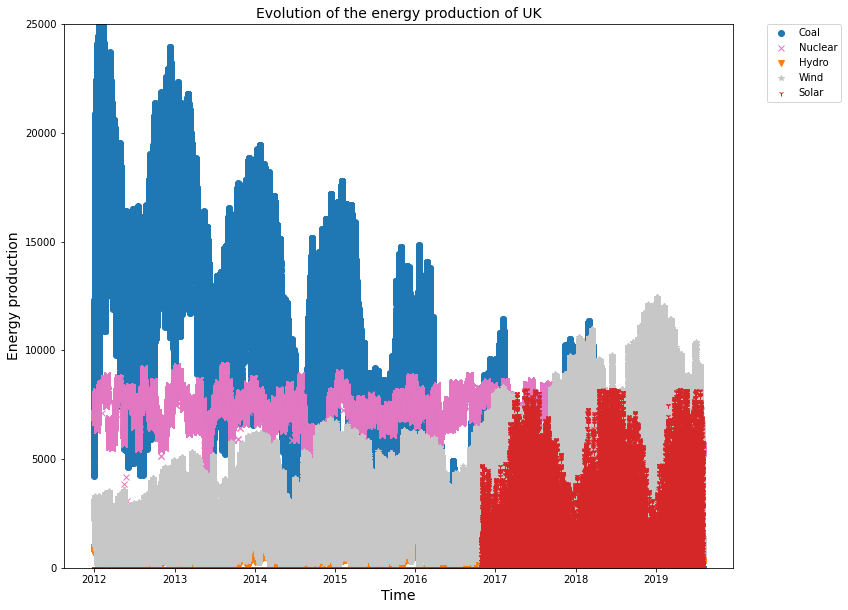

In [28]:
fig = plt.figure(figsize=(12,10))
plt.plot(df.Datetime, df.coal, 'o',label='Coal',color=tableau_colors[0])
plt.plot(df.Datetime, df.nuclear, 'x',label='Nuclear',color=tableau_colors[12])
plt.plot(df.Datetime, df.hydro, 'v',label='Hydro',color=tableau_colors[2])
plt.plot(df.Datetime, df.wind, '*',label='Wind',color=tableau_colors[15])
plt.plot(df.Datetime, df.solar, '1',label='Solar',color=tableau_colors[6])
plt.xlabel('Time', fontsize=14)
plt.ylim([0, 25000])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Energy production',  fontsize=14)
plt.title('Evolution of the energy production of UK', fontsize=14)

#### There is data registered every 5 minutes, but there is missing data, days with less data 

In [29]:
# data per 24 hours
(60/5)*24

288.0

In [30]:
#Total energy consumption 
df['total'] = df['coal'] + df['nuclear'] + df['wind'] + df['hydro'] + df['solar']

In [31]:
energy = df[['timestamp', 'coal', 'nuclear', 'wind', 'hydro', 'solar', 'total']]

In [32]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795335 entries, 0 to 796452
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  795335 non-null  object 
 1   coal       795335 non-null  int64  
 2   nuclear    795335 non-null  int64  
 3   wind       795335 non-null  int64  
 4   hydro      795335 non-null  int64  
 5   solar      795335 non-null  float64
 6   total      795335 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.5+ MB


In [33]:
energy['timestamp']=pd.to_datetime(energy['timestamp'], format='%Y-%m-%d %H:%M:%S')

/tmp/ipykernel_11543/1647554689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy['timestamp']=pd.to_datetime(energy['timestamp'], format='%Y-%m-%d %H:%M:%S')


In [34]:
energy = energy.set_index('timestamp')

In [35]:
energy_per_day = energy.loc[:'2019-07', :'total'].resample('D').mean()*288

In [36]:
energy_per_day.head(2)

,coal,nuclear,wind,hydro,solar,total
timestamp,,,,,,
2012-01-01,2.448325e+06,2.029537e+06,760388.000000,226484.000000,0.0,5.464734e+06
2012-01-02,2.938653e+06,2.037884e+06,795531.261324,224000.780488,0.0,5.996069e+06


In [37]:
energy_per_day.loc[:'2018', :'total'].resample('Y').sum().to_csv('energy_sum_year.csv')

In [38]:
energy_per_day.loc[:'2019-07', :'total'].resample('M').sum().to_csv('energy_sum_month.csv')

In [39]:
energy_per_day.loc[:'2019-07', :'total'].resample('W').sum().to_csv('energy_sum_week.csv')

In [40]:
data_per_date = df.groupby(['Date']).agg({'coal':'sum', 'nuclear':'sum', 'wind':'sum', 'hydro':'sum',
                                     'solar':'sum'})

In [41]:
energy_per_day.to_csv('energy_sum_day.csv')

In [95]:
energy_per_year = energy.loc[:'2019-07', :'total'].resample('Y').mean()*288*365

In [97]:
energy_per_year.reset_index(inplace=True)

In [99]:
energy_per_year['Year'] = energy_per_year['timestamp'].dt.year

Text(0.5, 1.0, 'Energy production in the UK for the period 2012 - 2019')

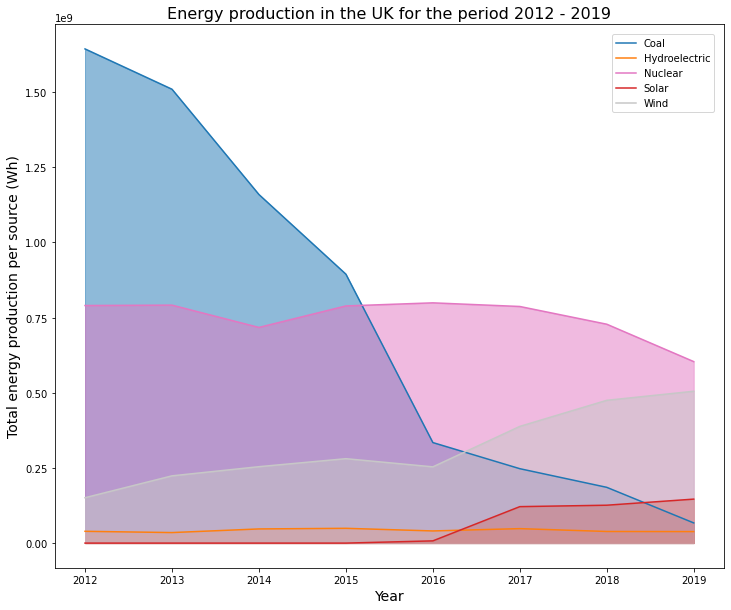

In [104]:
fig = plt.figure(figsize=(12,10))

plt.plot(energy_per_year.Year,energy_per_year['coal'],label='Coal',color=tableau_colors[0])
plt.plot(energy_per_year.Year,energy_per_year['hydro'],label='Hydroelectric',color=tableau_colors[2])
plt.plot(energy_per_year.Year,energy_per_year['nuclear'],label='Nuclear',color=tableau_colors[12])
plt.plot(energy_per_year.Year,energy_per_year['solar'],label='Solar',color=tableau_colors[6])
plt.plot(energy_per_year.Year,energy_per_year['wind'],label='Wind',color=tableau_colors[15])


fill_between(energy_per_year.Year,energy_per_year['coal'],0,alpha=0.5,color=tableau_colors[0])
fill_between(energy_per_year.Year,energy_per_year['hydro'],0,alpha=0.5,color=tableau_colors[2])
fill_between(energy_per_year.Year,energy_per_year['nuclear'],0,alpha=0.5,color=tableau_colors[12])
fill_between(energy_per_year.Year,energy_per_year['solar'],0,alpha=0.5,color=tableau_colors[6])
fill_between(energy_per_year.Year,energy_per_year['wind'],0,alpha=0.5,color=tableau_colors[15])

plt.legend(loc=1, borderaxespad=1.)
plt.xlabel('Year',  fontsize=14)
plt.ylabel('Total energy production per source (Wh)',  fontsize=14)
plt.title('Energy production in the UK for the period 2012 - 2019', fontsize=16)

In [90]:
data_year = df.groupby(['Year']).agg({'coal':'sum', 'nuclear':'sum', 'wind':'sum', 'hydro':'sum',
                                     'solar':'sum'})

In [91]:
data_year.head()

,coal,nuclear,wind,hydro,solar
Year,,,,,
2012,1645087562,790861427,151078697,39238211,0.000000e+00
2013,1503210001,788102326,222730765,34864525,0.000000e+00
2014,1155937679,715142055,253392828,46950972,0.000000e+00
2015,892033180,786664109,280012885,49017429,0.000000e+00
2016,333429670,796845361,252901834,40313404,7.374682e+06


In [92]:
data_year = data_year.reset_index()

Text(0.5, 1.0, 'Energy production in the UK for the periond 2012 - 2019')

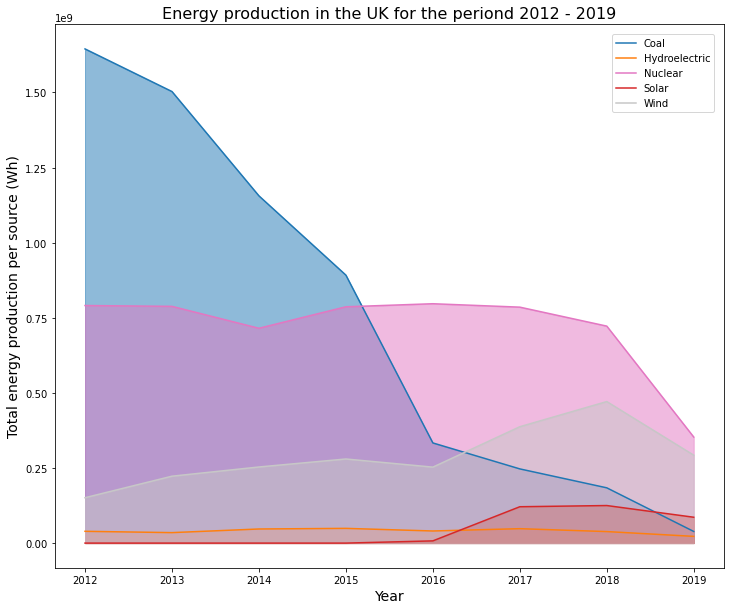

In [93]:
fig = plt.figure(figsize=(12,10))

plt.plot(data_year.Year,data_year['coal'],label='Coal',color=tableau_colors[0])
plt.plot(data_year.Year,data_year['hydro'],label='Hydroelectric',color=tableau_colors[2])
plt.plot(data_year.Year,data_year['nuclear'],label='Nuclear',color=tableau_colors[12])
plt.plot(data_year.Year,data_year['solar'],label='Solar',color=tableau_colors[6])
plt.plot(data_year.Year,data_year['wind'],label='Wind',color=tableau_colors[15])


fill_between(data_year.Year,data_year['coal'],0,alpha=0.5,color=tableau_colors[0])
fill_between(data_year.Year,data_year['hydro'],0,alpha=0.5,color=tableau_colors[2])
fill_between(data_year.Year,data_year['nuclear'],0,alpha=0.5,color=tableau_colors[12])
fill_between(data_year.Year,data_year['solar'],0,alpha=0.5,color=tableau_colors[6])
fill_between(data_year.Year,data_year['wind'],0,alpha=0.5,color=tableau_colors[15])

plt.legend(loc=1, borderaxespad=1.)
plt.xlabel('Year',  fontsize=14)
plt.ylabel('Total energy production per source (Wh)',  fontsize=14)
plt.title('Energy production in the UK for the periond 2012 - 2019', fontsize=16)

In [46]:
data_year.head()

,Year,coal,nuclear,wind,hydro,solar
0,2012,1645087562,790861427,151078697,39238211,0.000000e+00
1,2013,1503210001,788102326,222730765,34864525,0.000000e+00
2,2014,1155937679,715142055,253392828,46950972,0.000000e+00
3,2015,892033180,786664109,280012885,49017429,0.000000e+00
4,2016,333429670,796845361,252901834,40313404,7.374682e+06


In [47]:
data_year = after_groupby(data_year, reset=True, second_level_keep=False, columns_transform=False)

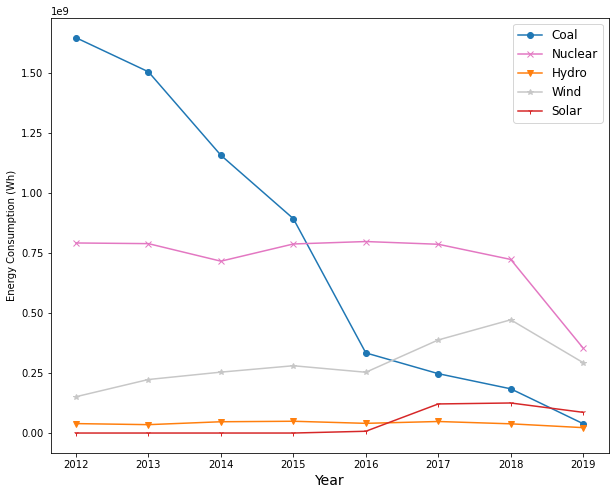

In [49]:
fig = plt.figure(figsize=(10,8))
plt.plot(data_year.Year, data_year.coal, 'o-',label='Coal',color=tableau_colors[0])
plt.plot(data_year.Year, data_year.nuclear, 'x-',label='Nuclear',color=tableau_colors[12])
plt.plot(data_year.Year, data_year.hydro, 'v-',label='Hydro',color=tableau_colors[2])
plt.plot(data_year.Year, data_year.wind, '*-',label='Wind',color=tableau_colors[15])
plt.plot(data_year.Year, data_year.solar, '1-',label='Solar',color=tableau_colors[6])
plt.ylabel('Energy Consumption (Wh)')
plt.xlabel('Year', fontsize=14)
plt.legend(loc=1, prop={'size': 12})
plt.show()

In [50]:
data_year_month = df.groupby(['Year', 'month_name']).agg({'coal':'sum', 'nuclear':'sum', 'wind':'sum', 'hydro':'sum',
                                     'solar':'sum'})

In [51]:
data_year_month.head()

coal   nuclear      wind    hydro  solar
Year month_name                                               
2012 April       138131821  69483429   9356536  1826985    0.0
     August      103005743  73273531   8903223  2099634    0.0
     December    161769714  70294584  22286563  4167241    0.0
     February    168961469  69634971  13625689  4660704    0.0
     January     155489744  68362466  15361910  6363291    0.0